# Predict the trend (rise or fall) of the stock price



# Install and import necessary library

In [1]:
!pip install yfinance --quiet
!pip install ta --quiet

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import yfinance as yf
import ta

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Get data from yahoo finance
As usual we get the data from yahoo finance.

In [3]:
ticker = 'TTE.PA'
df = yf.download(ticker)

[*********************100%%**********************]  1 of 1 completed


# Function to compute features (technical indicators)

We are going to write a function allowing us to complete our dataframe with a certain number of technical indicators and characteristics inherited from these technical indicators. The list is relatively long, not all of these characteristics will necessarily be used for training. The step of identifying the importance of each characteristic will help us make a selection in the second iteration.

In [4]:
def add_ta(df):
    df['Close_Shift'] = df['Close'].shift(1)
    df['Return'] = (df['Close']/df['Close_Shift'] - 1) * 100
    df['Return_lag1'] = df['Return'].shift(1)
    df['Return_lag2'] = df['Return'].shift(2)
    df['Return_lag3'] = df['Return'].shift(3)
    df['Return_lag4'] = df['Return'].shift(4)
    df['Return_lag5'] = df['Return'].shift(5)
    df['Return_bin'] = np.where(df['Return']>0, 1, 0)
    df['Return_lag1_bin'] = np.where(df['Return_lag1']>0, 1, 0)
    df['Return_lag2_bin'] = np.where(df['Return_lag2']>0, 1, 0)
    df['Return_lag3_bin'] = np.where(df['Return_lag3']>0, 1, 0)
    df['Return_lag4_bin'] = np.where(df['Return_lag4']>0, 1, 0)
    df['Return_lag5_bin'] = np.where(df['Return_lag5']>0, 1, 0)
    
    df['Close_lag1'] = df['Close'].shift(1)
    df['Close_lag2'] = df['Close'].shift(2)
    df['Close_lag3'] = df['Close'].shift(3)
    df['Close_lag4'] = df['Close'].shift(4)
    df['Close_lag5'] = df['Close'].shift(5)
    
    df['O-C'] = df['Open'] - df['Close']
    df['O-C_lag1'] = df['O-C'].shift(1)
    df['O-C_lag2'] = df['O-C'].shift(2)
    df['O-C_lag3'] = df['O-C'].shift(3)
    df['O-C_lag4'] = df['O-C'].shift(4)
    df['O-C_lag5'] = df['O-C'].shift(5)
    df['H-L'] = df['High'] - df['Low']
    df['H-L_lag1'] = df['H-L'].shift(1)
    df['H-L_lag2'] = df['H-L'].shift(2)
    df['H-L_lag3'] = df['H-L'].shift(3)
    df['H-L_lag4'] = df['H-L'].shift(4)
    df['H-L_lag5'] = df['H-L'].shift(5)
     
    # volatility
    df['volatility'] = df['Close'].pct_change().std()
    df['volatility_lag1'] = df['volatility'].shift(1)
    df['volatility_lag2'] = df['volatility'].shift(2)
    df['volatility_lag3'] = df['volatility'].shift(3)
    df['volatility_lag4'] = df['volatility'].shift(4)
    df['volatility_lag5'] = df['volatility'].shift(5)
    
    # Average True Range
    atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'])
    df['atr'] = atr.average_true_range()
    df['atr_lag1'] = df['atr'].shift(1)
    df['atr_lag2'] = df['atr'].shift(2)
    df['atr_lag3'] = df['atr'].shift(3)
    df['atr_lag4'] = df['atr'].shift(4)
    df['atr_lag5'] = df['atr'].shift(5)
    
     # Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Close'],window = 5)
    df['sma10'] = ta.trend.sma_indicator(df['Close'],window = 10)
    df['sma15'] = ta.trend.sma_indicator(df['Close'],window = 15)
    df['sma20'] = ta.trend.sma_indicator(df['Close'],window = 20)
    df['sma30'] = ta.trend.sma_indicator(df['Close'],window = 30)
    df['sma50'] = ta.trend.sma_indicator(df['Close'],window = 50)
    df['sma80'] = ta.trend.sma_indicator(df['Close'],window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Close'],window = 100)
    df['sma200'] = ta.trend.sma_indicator(df['Close'],window = 200)
    
    # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Close'] / df['sma5']
    df['sma5_ratio_lag1'] = df['sma5_ratio'].shift(1)
    df['sma5_ratio_lag2'] = df['sma5_ratio'].shift(2)
    df['sma5_ratio_lag3'] = df['sma5_ratio'].shift(3)
    df['sma10_ratio'] = df['Close'] / df['sma10']
    df['sma10_ratio_lag1'] = df['sma10_ratio'].shift(1)
    df['sma10_ratio_lag2'] = df['sma10_ratio'].shift(2)
    df['sma10_ratio_lag3'] = df['sma10_ratio'].shift(3)
    df['sma20_ratio'] = df['Close'] / df['sma20']
    df['sma30_ratio'] = df['Close'] / df['sma30'] 
    df['sma50_ratio'] = df['Close'] / df['sma50']
    df['sma80_ratio'] = df['Close'] / df['sma80']
    df['sma100_ratio'] = df['Close'] / df['sma100']
    df['sma200_ratio'] = df['Close'] / df['sma200']
    
    # Adding RSI, CCI, Bollinger Bands, and OBV

    df['rsi'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
    df['obv_lag1'] = df['obv'].shift(1)
    df['obv_lag2'] = df['obv'].shift(2)
    df['obv_lag3'] = df['obv'].shift(3)
    df['obv_lag4'] = df['obv'].shift(4)
    df['obv_lag5'] = df['obv'].shift(5)
    
    # Adding Rate Of Change Indicator
    roc2 = ta.momentum.ROCIndicator(close=df['Close'], window=2)
    df['roc2'] = roc2.roc()
    roc3 = ta.momentum.ROCIndicator(close=df['Close'], window=3)
    df['roc3'] = roc3.roc()
    roc4 = ta.momentum.ROCIndicator(close=df['Close'], window=4)
    df['roc4'] = roc4.roc()
    roc5 = ta.momentum.ROCIndicator(close=df['Close'], window=5)
    df['roc5'] = roc5.roc()
    
    # Adding MACD
    macd = ta.trend.MACD(close=df['Close'])
    df['macd_line'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    df['macd_line_above_signal'] = (df['macd_line'] > df['macd_signal']).astype(int)
    df['macd_diff_positive'] = (df['macd_diff'] > 0).astype(int)
    df['macd_line_crossover_signal'] = np.where((df['macd_line'].shift(1) < df['macd_signal'].shift(1)) & (df['macd_line'] > df['macd_signal']), 1, 0)
    
    # Adding features derived from the indicators above
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['rsi_lag1'] = df['rsi'].shift(1)
    df['rsi_lag2'] = df['rsi'].shift(2)
    df['rsi_lag3'] = df['rsi'].shift(3)
    df['rsi_lag4'] = df['rsi'].shift(4)
    df['rsi_lag5'] = df['rsi'].shift(5)
    df['above_bb_high'] = (df['Close'] >= df['bb_high']).astype(int)
    df['below_bb_low'] = (df['Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Close'].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['cci_lag1'] = df['cci'].shift(1)
    df['cci_lag2'] = df['cci'].shift(2)
    df['cci_lag3'] = df['cci'].shift(3)
    df['cci_lag4'] = df['cci'].shift(4)
    df['cci_lag5'] = df['cci'].shift(5)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    df['above_sma5'] = (df['Close'] > df['sma5']).astype(int)
    df['above_sma10'] = (df['Close'] > df['sma10']).astype(int)
    df['above_sma15'] = (df['Close'] > df['sma15']).astype(int)
    df['above_sma20'] = (df['Close'] > df['sma20']).astype(int)
    df['above_sma30'] = (df['Close'] > df['sma30']).astype(int)
    df['above_sma50'] = (df['Close'] > df['sma50']).astype(int)
    df['above_sma80'] = (df['Close'] > df['sma80']).astype(int)
    df['above_sma100'] = (df['Close'] > df['sma100']).astype(int)
    df['above_sma200'] = (df['Close'] > df['sma200']).astype(int)
    
    # Close price above sma
    df['above_sma5_lag1'] = df['above_sma5'].shift(1)
    df['above_sma5_lag2'] = df['above_sma5'].shift(2)
    df['above_sma5_lag3'] = df['above_sma5'].shift(3)
    df['above_sma5_lag4'] = df['above_sma5'].shift(4)
    df['above_sma5_lag5'] = df['above_sma5'].shift(5)
    
    df['above_sma10_lag1'] = df['above_sma10'].shift(1)
    df['above_sma10_lag2'] = df['above_sma10'].shift(2)
    df['above_sma10_lag3'] = df['above_sma10'].shift(3)
    df['above_sma10_lag4'] = df['above_sma10'].shift(4)
    df['above_sma10_lag5'] = df['above_sma10'].shift(5)
    
    df['above_sma15_lag1'] = df['above_sma15'].shift(1)
    df['above_sma15_lag2'] = df['above_sma15'].shift(2)
    df['above_sma15_lag3'] = df['above_sma15'].shift(3)
    df['above_sma15_lag4'] = df['above_sma15'].shift(4)
    df['above_sma15_lag5'] = df['above_sma15'].shift(5)
    
    df['above_sma20_lag1'] = df['above_sma20'].shift(1)
    df['above_sma20_lag2'] = df['above_sma20'].shift(2)
    df['above_sma20_lag3'] = df['above_sma20'].shift(3)
    df['above_sma20_lag4'] = df['above_sma20'].shift(4)
    df['above_sma20_lag5'] = df['above_sma20'].shift(5)

    df['above_sma30_lag1'] = df['above_sma30'].shift(1)
    df['above_sma30_lag2'] = df['above_sma30'].shift(2)
    df['above_sma30_lag3'] = df['above_sma30'].shift(3)
    df['above_sma30_lag4'] = df['above_sma30'].shift(4)
    df['above_sma30_lag5'] = df['above_sma30'].shift(5)
    
    df['above_sma50_lag1'] = df['above_sma50'].shift(1)
    df['above_sma50_lag2'] = df['above_sma50'].shift(2)
    df['above_sma50_lag3'] = df['above_sma50'].shift(3)
    df['above_sma50_lag4'] = df['above_sma50'].shift(4)
    df['above_sma50_lag5'] = df['above_sma50'].shift(5)
    
    df['above_sma80_lag1'] = df['above_sma80'].shift(1)
    df['above_sma80_lag2'] = df['above_sma80'].shift(2)
    df['above_sma80_lag3'] = df['above_sma80'].shift(3)
    df['above_sma80_lag4'] = df['above_sma80'].shift(4)
    df['above_sma80_lag5'] = df['above_sma80'].shift(5)
    
    # Removing NaN values from the dataframe 
    df.dropna(inplace = True)
    return df

# Function to Label the dataset
Data labeling is still a problem for me. I carried out several tests and my choice fell on the trend of the sma5.   
We label our data as 1 if the next sma5 is greater than the current sma5 which does not always mean a higher next closing price. To prevent this phenomenon I add a threshold of 0.2%.

In [5]:
def add_target(df):
    df['target'] = np.where(
        (df['sma5'].shift(-1) > df['sma5']*1.002) 
        , 1, 0)
    return df

# Compute features engineering and label the dataset
In this part, we just call the function to add the features and to label our datasets.

In [6]:
df = add_ta(df)
df = add_target(df)

/tmp/ipykernel_18/1630670901.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cci_lag1'] = df['cci'].shift(1)
/tmp/ipykernel_18/1630670901.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cci_lag2'] = df['cci'].shift(2)
/tmp/ipykernel_18/1630670901.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

# Check if the class are imbalanced
We are in a classification problem, the classes must be balanced at the risk of having a good score due to the predominance of one class.

<Axes: xlabel='target', ylabel='Count'>

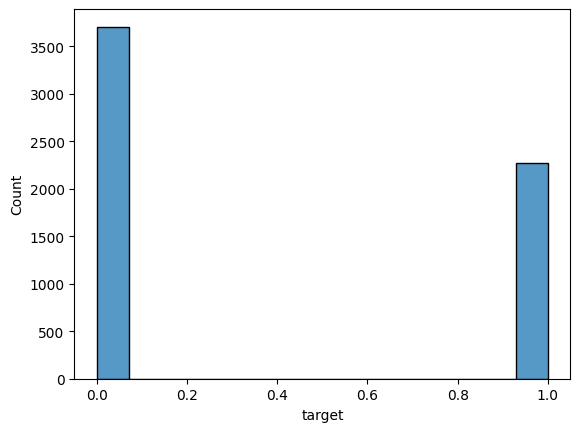

In [7]:
import seaborn as sns
sns.histplot(df, x='target')

The classes are not exactly balanced.

# train/test split

In [8]:
features = ['Open', 'High', 'Low', 'Close', 
            #'Adj Close', 
            #'Volume', 
            #'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_lag4', 'Close_lag5', 
            'Return', 
            #'Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5',
            'O-C', 
            'O-C_lag1','O-C_lag2','O-C_lag3','O-C_lag4','O-C_lag5',
            'H-L',
            'H-L_lag1', 'H-L_lag2', 'H-L_lag3', 'H-L_lag4','H-L_lag5',
            'sma5', 'sma10', 'sma15', 'sma20', 'sma30', 'sma50', 'sma80', 'sma100', 'sma200', 
            #'sma5 > sma10', 'sma10 > sma15', 'sma15 > sma20', 'sma20 > sma30', 'sma30 > sma50', 'sma50 > sma80', 'sma80 > sma100','sma100 > sma200',
            #'above_sma5', 'above_sma10', 'above_sma15', 'above_sma20', 'above_sma30', 'above_sma50', 'above_sma80', 'above_sma100', 'above_sma200',
            #'above_sma5_lag1', 'above_sma5_lag2', 'above_sma5_lag3', 'above_sma5_lag4', 'above_sma5_lag5',
            #'above_sma10_lag1', 'above_sma10_lag2', 'above_sma10_lag3', 'above_sma10_lag4', 'above_sma10_lag5',
            #'above_sma15_lag1', 'above_sma15_lag2', 'above_sma15_lag3', 'above_sma15_lag4', 'above_sma15_lag5',
            #'above_sma30_lag1', 'above_sma30_lag2', 'above_sma30_lag3', 'above_sma30_lag4', 'above_sma30_lag5',
            #'above_sma50_lag1', 'above_sma50_lag2', 'above_sma50_lag3', 'above_sma50_lag4', 'above_sma50_lag5',
            #'above_sma80_lag1', 'above_sma80_lag2', 'above_sma80_lag3', 'above_sma80_lag4', 'above_sma80_lag5',           
            'sma5_ratio', 'sma10_ratio', 'sma20_ratio', 'sma30_ratio', 'sma50_ratio', 'sma80_ratio', 'sma100_ratio', 'sma200_ratio', 
            'sma5_ratio_lag1', 'sma5_ratio_lag2', 'sma5_ratio_lag3',
            'sma10_ratio_lag1', 'sma10_ratio_lag2', 'sma10_ratio_lag3',
            'rsi', 'rsi_lag1', 'rsi_lag2', 'rsi_lag3', 'rsi_lag4', 'rsi_lag5', 
            'rsi_overbought', 'rsi_oversold', 
            #'cci', 'cci_lag1', 'cci_lag2', 'cci_lag3', 'cci_lag4', 'cci_lag5', 
            #'cci_high','cci_low',
            'bb_high', 'bb_low', 
            #'above_bb_high', 'below_bb_low', 
            'obv',
            'obv_divergence_10_days', 'obv_divergence_20_days', 
            #'obv_lag1', 'obv_lag2', 'obv_lag3', 'obv_lag4', 'obv_lag5',
            'macd_line', 'macd_signal', 'macd_diff', 'macd_line_above_signal', 'macd_diff_positive', 'macd_line_crossover_signal',
            #'volatility', 'volatility_lag1', 'volatility_lag2', 'volatility_lag3', 'volatility_lag4', 'volatility_lag5',
            'atr', 
            #'atr_lag1', 'atr_lag2', 'atr_lag3', 'atr_lag4', 'atr_lag5',
            #'Return_bin', 'Return_lag1_bin', 'Return_lag2_bin', 'Return_lag3_bin', 'Return_lag4_bin', 'Return_lag5_bin'
            'roc2', 'roc3', 'roc4', 'roc5',
           ]
target = 'target'
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

# Select and Fit the model
In this part, we select 6 classifiers and identify which is the best for the next step.   
We will use the Area Under the ROC Curve (AUC) score, which is a popular metric to evaluate the performance of binary classifiers. Overall, an AUC score equal to 0.5 indicates a model that performs just as good as a random guessing, while an AUC score equal to 1.0 indicates a classifier that can correctly predict every single class of our target variable.   

1. we establish the list of classifiers to use
1. for each classifier we train the model, make a prediction and calculate the AUC ROC score. This involves making the proportion of true positives based on the proportion of false positives.

In [9]:
classifiers = [
    LogisticRegression(random_state = 42),
    XGBClassifier(random_state = 42),
    LGBMClassifier(random_state = 42),
    CatBoostClassifier(random_state = 42, verbose = False),
    AdaBoostClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'{type(clf).__name__}: AUC Score = {auc_score:.3f}')

LogisticRegression: AUC Score = 0.694
XGBClassifier: AUC Score = 0.916
LGBMClassifier: AUC Score = 0.927
CatBoostClassifier: AUC Score = 0.933
AdaBoostClassifier: AUC Score = 0.921
RandomForestClassifier: AUC Score = 0.923



 AdaBoostClassifier AUC Score = 0.921 



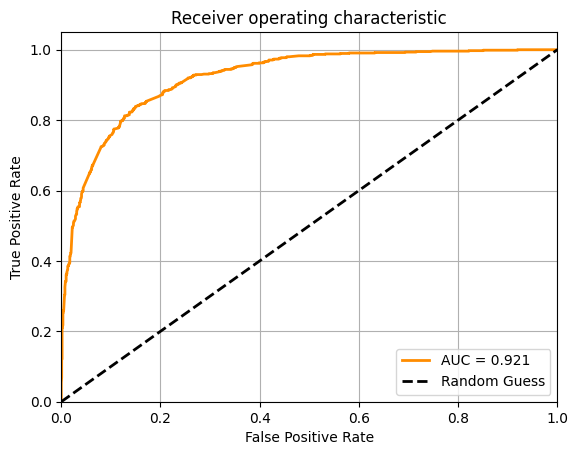

In [10]:
import matplotlib.pyplot as plt
# Creating AdaBoostClassifier Model 
model = AdaBoostClassifier(random_state = 42)
# model = RandomForestClassifier(random_state = 42)
# model = CatBoostClassifier(random_state = 42, verbose=False)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'\n {type(model).__name__} AUC Score = {auc_score:.3f} \n')

# Plotting AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Features Importance

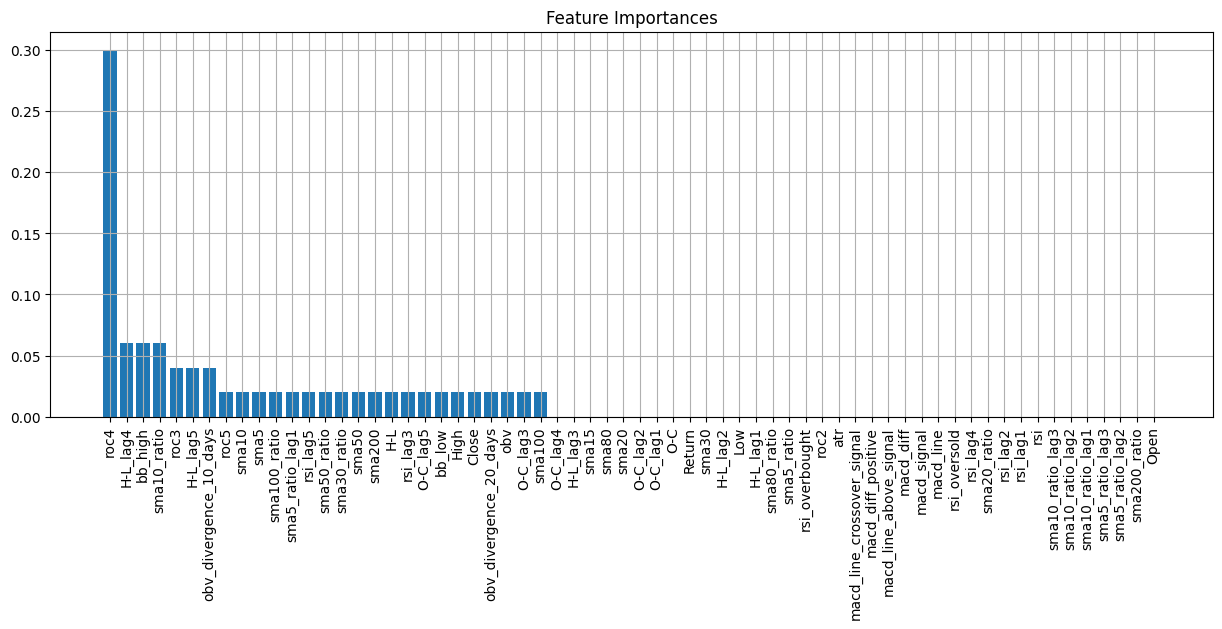

In [11]:
# Plotting Feature Importances 
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.grid(True)
plt.show()

# Probability analyze
We cut our prediction in 10 quantile and plot the prediction. This step will help us to determine the best treshold to buy.

<Axes: xlabel='row_0'>

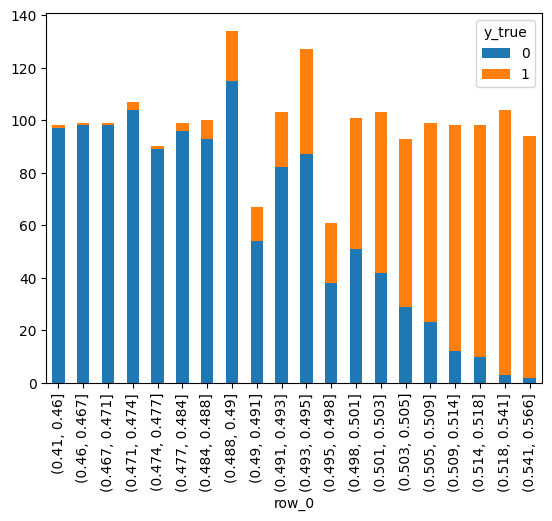

In [12]:
quantile_intervals = np.arange(0, 1.05, 0.05)
quantile_values = np.quantile(y_pred, quantile_intervals)
classes = pd.cut(y_pred, quantile_values)
X_test['y_true'] = y_test
pred_table = pd.crosstab(classes, X_test['y_true']) 
pred_table.plot(kind="bar", stacked=True, rot=90)

# Conclusion
We can conclude if y_pred is in the 2 last quantile, the probability to have a positif a next day's sma5 higher than actual sma5 is very good.